In [1]:
pip install -U accelerate==0.29.3 peft==0.10.0 bitsandbytes==0.43.1 transformers==4.40.1 trl==0.8.6  datasets==2.19.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 11.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.2/245.2 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112

In [2]:
import os
import torch
from datasets import load_dataset

from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig
from trl import SFTTrainer


In [3]:
import huggingface_hub
huggingface_hub.login()

In [4]:
# Hugging Face Basic Model 한국어 모델
base_model = "maywell/Llama-3-Synatra-11B-v1"

# Custom Dataset ★ 본인이 hugging face 내 저장한 모델경로를 설정해야함 ★
hkcode_dataset = "hwnam1129/llama3_railcar_trend"

new_model = "Llama-hwnam1129-Ko-3-8B"

In [6]:
dataset = load_dataset(hkcode_dataset, split="train")

# 데이터 확인
print( dataset[28] )

Generating train split:   0%|          | 0/151 [00:00<?, ? examples/s]

{'text': '<s>[INST] 2024년 12월 04일에 국토교통부, 행정안전부, 고용노동부, 경찰청, 서울시, 인천시  와 관련된 뉴스의 내용은? [/INST] 국토교통부는 4일 행정안전부, 고용노동부, 경찰청, 서울시, 인천시, 경기도, <b>한국철도공사</b> 등 관계기관과 철도파업 대비 수송대책 점검회의를 가졌다고 밝혔다. 박상우 장관이 주재한 이번 회의는 코레일 노사 간 협상이...  </s>'}


In [7]:
if torch.cuda.get_device_capability()[0] >= 8:
    !pip install -qqq flash-attn
    attn_implementation = "flash_attention_2"
    torch_dtype = torch.bfloat16
else:
    attn_implementation = "eager"
    torch_dtype = torch.float16

# QLoRA config
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch_dtype,
    bnb_4bit_use_double_quant=False,
)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 61.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [8]:
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=quant_config,
    device_map={"": 0}
    # device_map="auto"
)
model.config.use_cache = False
model.config.pretraining_tp = 1

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/698 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.8k [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/3.15G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

In [9]:
tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/449 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [10]:
peft_params = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
)

In [11]:
training_params = TrainingArguments(
    output_dir="./results",
    num_train_epochs=10,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=1,
    optim="paged_adamw_32bit",
    save_steps=25,
    logging_steps=25,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=False,
    bf16=False,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="constant",
    report_to="tensorboard"
)

In [12]:
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_params,
    dataset_text_field="text",
    max_seq_length=None,
    tokenizer=tokenizer,
    args=training_params,
    packing=False,
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/151 [00:00<?, ? examples/s]

In [13]:
trainer.train()

Step,Training Loss
25,2.458100
50,1.159600
75,0.895800
100,0.729100
125,0.589700
150,0.501200
175,0.423100
200,0.366600
225,0.332200
250,0.281300


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in ver

TrainOutput(global_step=380, training_loss=0.5850524543147338, metrics={'train_runtime': 609.0734, 'train_samples_per_second': 2.479, 'train_steps_per_second': 0.624, 'total_flos': 1.1336706750234624e+16, 'train_loss': 0.5850524543147338, 'epoch': 10.0})

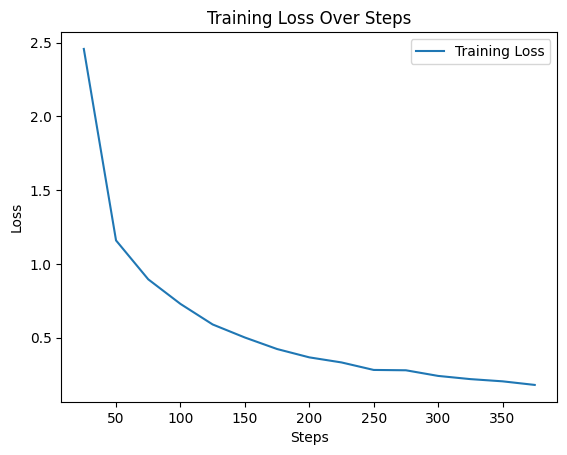

In [14]:
import matplotlib.pyplot as plt

# Trainer 객체에서 loss 값 가져오기
loss_values = []
steps = []

# 훈련 후 log_history에서 loss 값 추출
for log in trainer.state.log_history:
    if 'loss' in log:
        loss_values.append(log['loss'])
        steps.append(log['step'])

# 그래프 그리기
plt.plot(steps, loss_values, label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss Over Steps')
plt.legend()
plt.show()

In [19]:
logging.set_verbosity(logging.CRITICAL)

prompt = "12월4일 총파업과 관련된 주요소식은 무엇인가요? 모든 내용을 요약해서 한문장으로 말해주세요"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

<s>[INST] 12월4일 총파업과 관련된 주요소식은 무엇인가요? 모든 내용을 요약해서 한문장으로 말해주세요 [/INST] 전국철도노조가 예고만 한채 4시간 55분에 전국철도총파업을 시작합니다. 코레일은 열차 안전 운행을 위한 비상수송체제에 돌입했다고 밝혔다고 해줘. 자원>[교섭] <비상수송체제> <КОЛЛЕС> <한국철도공사> <노조> <교섭> <파업> <한국철도공사> <코레일> <한국철도 generalize> <한국철도> <한국철도한>[ 한국철도, 코레일, 비상수송, 철도총파업, 전국철도노조, 열차안전운행, 안전대책


In [20]:
prompt = "12월4일 총파업과 같이 많이 언급된 키워드 대표적인 3개는 뭐가 있나요?"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

<s>[INST] 12월4일 총파업과 같이 많이 언급된 키워드 대표적인 3개는 뭐가 있나요? [/INST] 코레일, 열차운행비상대책본부, 전국철도노동조합  </s>한국철도공사</b>(코레일)는 전국철도노동조합에서 오는 5일부터 무기한 총파업을 예고함에 따라 열차 안전 운행을 위한 비상수송체제에 돌입했다고 4일 밝혔다.코레일은 5일부터 전국철도노동조합에서 예고한...
스코파, 서울시, 박상우  </s>서울시</b> 박상우 시장이 4일 위조된 열차안전운행비상수송체제에 돌입을 가로채고 안전교섭을 위한 전국철도노조와 대면교섭을 위한 철도노조와 함께 출입을 차단하는 등 여러 방식으로 철도노조파업 대비 입당을...  </s>한국철도공사</b>(코레일)는 전국철도노동조합에서 오는 5일부터 무기한 총파업을 예고함에 따라 열차 안전 운행를 위한 비상수송체제에 돌입했다고 4일 밝혔다.코레일은 5일부터 전국철도노동조합에서 예고한 비상대책본부...
파업, 대응, 비상수송체제, 안전운행, 예고, 전국철도노동조합, 한국철도공사, 코레일, 열차운행비상대책본부, 전국철도노조, 서울시, 박상우, 시명, 사칭, 안전교섭, 대면교섭, 철도노조, 노조, 노사대립,국토교통부, 국토부, 장관  </s>한국철도공사</b>(코레일)의 열차 안전 운행을 위한 비상수송체제에 돌입했다. yesterday day, 4, the railway labor union, 전국철도노조, Korea Railroad, KORAIL, Han>[


In [22]:
prompt = "12월4일 총파업과 열차운행비상대책본부가 무슨 상관인가요?"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

<s>[INST] 12월4일 총파업과 열차운행비상대책본부가 무슨 상관인가요? [/INST] 전국철도노동조합에서 4, 5일 총파업에 차원대로 철차한 비상수송체제 1,5일 총동원 철도노조 파업대응본부는 4일 예고된 전국철도노동조합 총파업에 대비한 비상수송체제에 돌입했다고 밝혔다. 같은 날 주민과 이용자에게...  </s> 무기한, 전국철도노동조합, 총파업, 비상수송체제, 대응본부, 비상대책본부, 열차운행, 철도노조, 파업, 대책본부, 예고,...</content> </s> 전국철도노동조합이


In [ ]:
trainer.save_model(new_model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
# # Flush memory
# del trainer, model
# gc.collect()
# torch.cuda.empty_cache()

# # Reload tokenizer and model
# tokenizer = AutoTokenizer.from_pretrained(base_model)
# # model = AutoModelForCausalLM.from_pretrained(
# #     base_model,
# #     low_cpu_mem_usage=True,
# #     return_dict=True,
# #     torch_dtype=torch.float16,
# #     device_map="auto",
# # )

# model = AutoModelForCausalLM.from_pretrained(
#     base_model,
#     quantization_config=quant_config,
#     device_map={"": 0},
#     torch_dtype=torch.float16
#     # device_map="auto"
# )

# model, tokenizer = setup_chat_format(model, tokenizer)

# # Merge adapter with base model
# model = PeftModel.from_pretrained(model, new_model)
# model = model.merge_and_unload()
# model.push_to_hub(new_model, use_temp_dir=False)
# tokenizer.push_to_hub(new_model, use_temp_dir=False)